![DSME-logo](./utils/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---
Notebook Authors: Lukas Kesper

In this example, we use a first-visit Monte Carlo control algorithm to find an optimal policy for the Frozen Lake environment from ["Gymnasium."](https://gymnasium.farama.org/index.html#). An example of the environment is shown below. The goal is to move the elf to the gift without entering one of the ice holes. The state is the position on the grid, and we can move the elf into the same four directions in each state.

<img src="./utils/frozen_lake.gif" alt="Example of Frozen_Lake" width="800">   

Reference: [Reinforcement Learning: An Introduction, by Richard S. Sutton and Andrew G. Barto](http://incompleteideas.net/book/the-book-2nd.html), 

## Library Imports

In [1]:
import gymnasium as gym
from collections import defaultdict 
import matplotlib.pyplot as plt
import numpy as np
import custom_envs
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
from IPython.display import Video
from IPython.display import display
from screeninfo import get_monitors
from typing import Optional
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Initializations
### Initializing the Agent

Monte Carlo (MC) algorithms are a class of algorithms capable of finding the optimal policy for an environment without needing a model of the environment. In this example, we use the fact, that the action space is independent of the state space. This is a common assumption in reinforcement learning implementations, which allows for a straightforward presentation of the algorithm. However, there are some environments, where this assumption doesn't hold, e.g. the recycling robot from the lecture.

Our `Agent` interacts with the environment to obtain an optimal policy via first-visit Monte Carlo control. MC methods sample and average returns for each state–action pair to estimate the action-value function. Notice that the first-visit characteristic comes from the fact that we always use the return following the *first* visit of a state action pair for estimation. We show the algorithm below.

<img src="./utils/first_visit_mc.png" alt="Every-visit Monte Carlo control algorithm" width="500">   

The training loop can be found in the method `train`. Please note that we call the Q-function `action_value_fn`. Just like in the algorithm above, we use an $\epsilon$-greedy policy via the `epsilon_greedy_policy` method, to ensure exploration. The randomness can be set via the parameter `epsilon`.
*Note*: Our implementation of `epsilon_greedy_policy` differs slightly from the pseudocode shown above, however, it results in a similar behavior.

In [2]:
class Agent():
    def __init__(self, env, gamma=0.9, epsilon=0.1):
        self.env = env
        self.ret_sum = defaultdict(float) # Keeping track of sum of reward in each state
        self.ret_count = defaultdict(float) # Keeping track of count in each state
        self.action_value_fn = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.gamma = gamma
        self.epsilon = epsilon # choose 0.0 to make a totally greedy policy, 1.0 for a fully random policy

    def get_random_action(self):
        random_action = np.random.choice(range(self.env.action_space.n))
        return random_action
    def get_best_action(self, obs):
        best_action = np.random.choice(np.flatnonzero(np.isclose(self.action_value_fn[obs], self.action_value_fn[obs].max(),
                                                                 rtol=0.01)))
        return best_action
    def epsilon_greedy_policy(self, obs):
        # returns action, choosing a random action with probability epsilon, or the best action
        # regarding to Q with probability (1 - epsilon)
        randomly = np.random.random() < self.epsilon
        if randomly:
            action = self.get_random_action()
        else:
            action = self.get_best_action(obs)
        return action

    def train(self, num_episodes, episode_max_duration=100):
        # Run through episodes sampled to improve policy incrementally
        for i_episode in range(1, num_episodes + 1):
            # Generate an episode, an array of (state, action, reward) tuples
            episode = []
            obs, info = env.reset()
            for t in range(episode_max_duration):
                action = self.epsilon_greedy_policy(obs)
                next_obs, reward, done, truncated, info = env.step(action)
                episode.append((obs, action, reward))
                if done:
                    break
                obs = next_obs
            episode = np.array(episode)
            episode_duration = len(episode[:,:1])
            # Calculate returns for the whole episode from the back to save memory and resources
            G = np.zeros([episode_duration, ])
            for i in range(episode_duration - 1, -1, -1):
                if i + 1 > episode_duration - 1:
                    G[i] = episode[i][2] # Last step of the episode
                else:
                    G[i] = episode[i][2] + self.gamma * G[i + 1]  # Every other step #!
            # Find indices of first visits of state-action pairs in the episode
            first_visit_indices = sorted(np.unique(episode[:,:2], return_index=True, axis=0)[1])
            # Update the policy with average over all episodes
            for index in first_visit_indices:
                state = episode[index][0]
                action = episode[index][1]
                self.ret_sum[(state, action)] += G[index]
                self.ret_count[(state, action)] += 1.0
                update = self.ret_sum[(state, action)] / self.ret_count[(state, action)]
                self.action_value_fn[int(state)][int(action)] = update
            if i_episode % 500 == 0:
                self.visualize(i_episode)

### Preparing the Evaluation

For evaluation, we require methods that visualize the Q-function (`visualize`), as well as a method that is used to evaluate the resulting policy (`evaluate`). We add these methods below.

In [3]:
def visualize(self, epoch): 
    fig, ax=plt.subplots(figsize=(7,5))
    lines = 4
    rows = 4        
    # Define grid positions:
    pos_x_left = 0.2
    pos_x_mid = 0.5
    pos_x_right = 0.8
    pos_y_up = 0.2
    pos_y_mid = 0.5
    pos_y_down = 0.8
    grid_size = {'x': lines, 'y': rows}
    def gridcreator(pos_x, pos_y):
        grid = []
        for i in range(grid_size['x']):
            for j in range(grid_size['y']):
                x = pos_x + j
                y = pos_y + i
                grid.append((x, y))
        return grid
    top = self.action_value_fn[:,3].reshape((lines, rows))
    top_value_positions = gridcreator(pos_x_mid, pos_y_up)
    right = self.action_value_fn[:,2].reshape((lines, rows))
    right_value_positions = gridcreator(pos_x_right, pos_y_mid)
    bottom = self.action_value_fn[:,1].reshape((lines, rows))
    bottom_value_positions = gridcreator(pos_x_mid, pos_y_down)
    left= self.action_value_fn[:,0].reshape((lines, rows))
    left_value_positions = gridcreator(pos_x_left, pos_y_mid)
    # Define triangles
    ax.set_ylim(lines, 0)
    anchor_points = np.array([[0,0],[0,1],[.5,.5],[1,0],[1,1]]) # Corner coordinates
    corner_indizes = np.array([[0,1,2], [0,2,3],[2,3,4],[1,2,4]]) # Corner indices
    xy_coordinates = np.zeros((lines * rows * 5,2))
    triangles = np.zeros((lines * rows * 4, 3))
    for i in range(lines):
        for j in range(rows):
            k = i*rows+j
            xy_coordinates[k*5:(k+1)*5,:] = np.c_[anchor_points[:,0]+j, 
                                                  anchor_points[:,1]+i]
            triangles[k*4:(k+1)*4,:] = corner_indizes + k*5
    colours = np.c_[left.flatten(), top.flatten(), 
            right.flatten(), bottom.flatten()].flatten()
    ax.triplot(xy_coordinates[:,0], xy_coordinates[:,1], triangles, 
               **{"color":"k", "lw":1})
    tripcolor = ax.tripcolor(xy_coordinates[:,0], xy_coordinates[:,1], triangles, 
                             facecolors=colours, **{"cmap": "coolwarm"})
    ax.margins(0)
    ax.set_aspect("equal")
    fig.colorbar(tripcolor)
    # Define text:
    textsize = 10
    for i, (xi,yi) in enumerate(top_value_positions):
        plt.text(xi,yi,round(top.flatten()[i],2), size=textsize, color="w", 
                 ha='center', va='center')
    for i, (xi,yi) in enumerate(right_value_positions):
        plt.text(xi,yi,round(right.flatten()[i],2), size=textsize, color="w", 
                 ha='center', va='center')
    for i, (xi,yi) in enumerate(left_value_positions):
        plt.text(xi,yi,round(left.flatten()[i],2), size=textsize, color="w", 
                 ha='center', va='center')
    for i, (xi,yi) in enumerate(bottom_value_positions):
        plt.text(xi,yi,round(bottom.flatten()[i],2), size=textsize, color="w", 
                 ha='center', va='center')
    ax.axis('off')
    plt.title("Q-Function, Epoch "+str(epoch))
    # add lines for separation
    for i in range(lines+1):
        x = [0, rows]
        y = [i, i]
        plt.plot(x,y, color='black')
    for i in range(rows+1):
        x = [i, i]
        y = [0, lines]
        plt.plot(x,y, color='black')
    plt.show()

def evaluate(self, env, file, num_runs=5):
    frames = []  # collect rgb_image of agent env interaction
    video_created = False
    for _ in range(num_runs):
        done = False
        obs, info = env.reset()
        out = env.render()
        frames.append(out)
        while not done:
            action = self.get_best_action(obs) 
            obs, reward, done, truncated, info = env.step(action)
            out = env.render()
            frames.append(out)              
    # create animation out of saved frames
    if all(frame is not None for frame in frames):
        fig = plt.figure(figsize=(10, 6))
        plt.axis('off')
        img = plt.imshow(frames[0])
        def animate(index):
            img.set_data(frames[index])
            return [img]
        anim = FuncAnimation(fig, animate, frames=len(frames), interval=20)
        plt.close()
        anim.save(file, writer="ffmpeg", fps=5)

setattr(Agent, 'visualize', visualize)
setattr(Agent, 'evaluate', evaluate)

## Training and Evaluation
Now we train the agent with the algorithm we implemented earlier and evaluate its performance.

### Setting up Agent and Environment
We start by setting up the environment, which is part of our custom environments. We create the environment using `Gymnasium` and a custom map. Here, we invite students to explore how the training changes when the position of holes (H) and Frozen plates (F). Then, we set up an Agent for training. Initially, our Q-function only consists of zeros, but changes during training.

In [4]:
map = ["SFFH", "FFFH", "HFFH", "HFFG"]
env = gym.make('CustomFrozenLake-v1', render_mode=None, desc=map, is_slippery=False)
env.reset()
agent = Agent(env, gamma=0.9, epsilon=0.1)

### Training the Agent

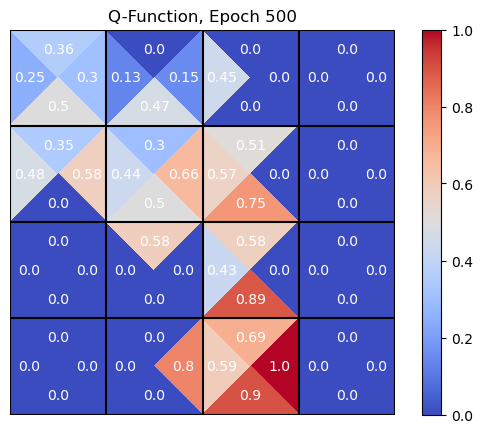

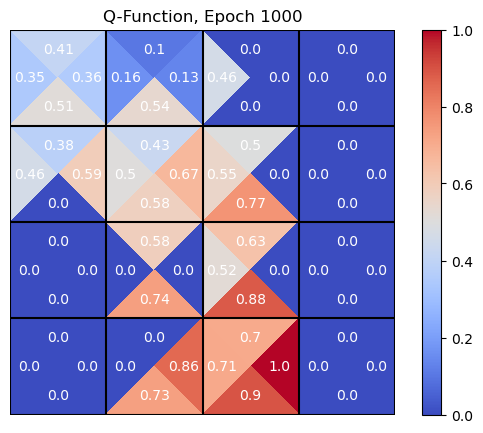

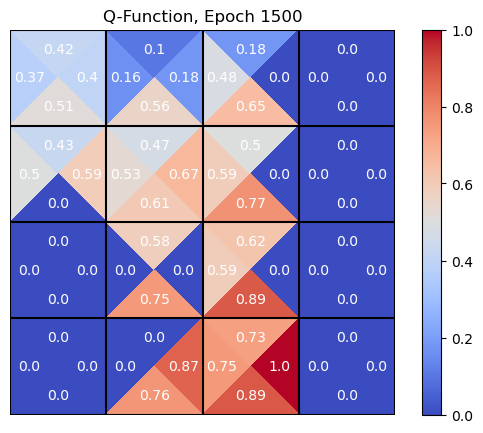

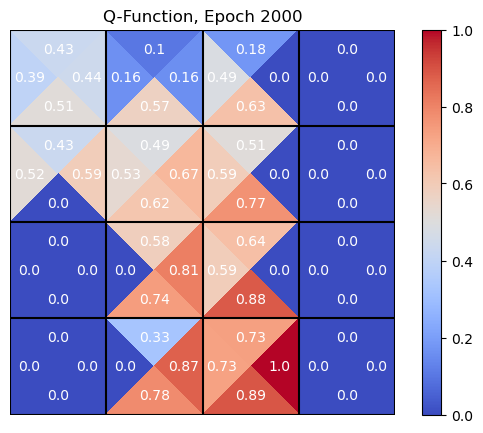

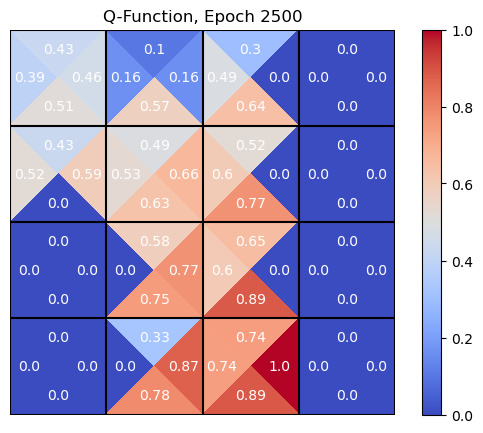

In [5]:
agent.train(num_episodes=2500)

### Evaluation

Above, we can see the evolution of the Q-function during training. The coloring already indicates what a greedy policy can look like. Below we show a greedy policy in the environment.

In [6]:
env = gym.make('CustomFrozenLake-v1', render_mode='rgb_array', desc=map, is_slippery=False)
video = "first_visit.mp4"
agent.evaluate(env, video, num_runs=5)
Video(video, html_attributes="loop autoplay")